# Quantum Gate Decomposition

Implementación de un sistema de descomposición de puertas cuánticas descrito en [arXiv:2203.04426](https://arxiv.org/abs/2203.04426)

1/7/2022 Roberto Losada García

In [108]:
#from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, quantum_info, execute, transpile, assemble, IBMQ
#from qiskit.circuit import Gate
#from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
#from qiskit.quantum_info import Statevector,random_statevector
#from qiskit.extensions import Initialize
#from qiskit.tools.monitor import job_monitor
#from qiskit.visualization import array_to_latex
#from qiskit.providers.ibmq import least_busy

from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.extensions import *
from qiskit.tools.monitor import *
from qiskit.providers.ibmq import *
from qiskit.circuit import *
from qiskit.circuit.library import*
from qiskit.transpiler.passes import RemoveBarriers

#import Our_Qiskit_Functions as oq
import sympy as sy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as m
import scipy as sc
import copy

from ipywidgets import interactive
# from IPython.core.display import display 
from IPython.display import display

In [109]:
S_simulator = Aer.backends(name='statevector_simulator')[0]
M_simulator = Aer.backends(name='qasm_simulator')[0]
U_simulator = Aer.get_backend('unitary_simulator')
# IBMQ.enable_account('690f441b74197a4d72968214bf5d7c446e999c114dcf7247f821a9604c4ac2d1136815105e210fc44485bd885148d815e441135c43f7bc7668195a5911f6cb01')
# provider = IBMQ.get_provider(hub='ibm-q')
# backend = provider.get_backend('ibmq_qasm_simulator')

In [110]:
#mpl.rcParams['figure.dpi'] = 75
large_width = 4000
np.set_printoptions(linewidth=large_width)

# 

## Definiciones preliminares

### Productos recursivos:

OJO: Los inputs son arrays $\left[w_0,...,w_{(n-1)}\right]$ y devuelven $ \displaystyle \bigwedge \left( w_{n-1}, \ldots \bigwedge \left( w_1, w_{0} \right) \right)$ donde $\bigwedge \left( \cdot , \cdot \right)$ es la operación a realizar

In [111]:
# Producto de Kroenecker recursivo
def RKron(w:np.ndarray)->np.ndarray:
    w_aux=w[0]
    for s in range(1,len(w)):
        w_aux = np.kron(w[s],w_aux)
    return w_aux

# Producto tensorial recursivo
def RProd(w:np.ndarray)->np.ndarray:
    w_aux=w[0]
    for s in range(1,len(w)):
        w_aux = np.tensordot(w[s],w_aux,axes=1)
    return w_aux

# Producto matricial recursivo
def RMult(w:np.ndarray)->np.ndarray:
    w_aux=w[0]
    for s in range(1,len(w)):
        w_aux = np.matmul(w[s],w_aux)
    return w_aux

### Indexaciones de parámetros:

In [112]:
#Parámetros iniciales:

# #nº qbits
n=4


#Para n qbits hay un mínimo teórico de "layers" para desentrelazarlo de los (n-1) restantes:
#Para 2 qbits,3; para 3, 14; pueden consultarse en la referencia.
limites_puertas=[3,14,63,267]

#Nº de ciclos a implementar 
cycles=limites_puertas[0:n-1]
cycles.reverse()

# #Orden de desentrelazamiento para los qbits
# #Por defecto empezamos desentrelazando q_{n-1}-->q_{1} (puede cambiarse)
disent_order=list(range(n-1,-1,-1))


#Lista con la prioridad u orden para montar las layers del circuito:
#Realmente para cada qbit puede haber una prioridad distinta, pero por
#defecto ponemos que la prioridad general es q_{n-1}->q_{0}

#Definimos un diccionario que recoge el orden de desentrelazado y
#la prioridad de desentrelazado de cada qbit: (disentanglement_dictionary)
def disent_dict(disent_order:list):
    disent_dict={}
    disent_qbits=[]
    for k in disent_order:
        disent_qbits.append(k)
        disent_dict[k]=[q for q in disent_order if not q in disent_qbits]
    return disent_dict
dis = disent_dict(disent_order)

# #Rotaciones en las capas unitarias; en la capa final
# #[layer_mode(cx,U3cx,cz,U3cz); final_rotation_mode(rx,rz,U3)]
# mode=['cx','U3']

# #Inicializacion ('qft','invqft','random';'array_unitario_a_inplementar')
# initial='qft'

# #Juntamos todas las condiciones:
# conditions = [n,dis,cycles,mode,initial]
# # conditions

In [113]:
# def PD(conditions:list):
#     n,dis,cycles,mode,initial = conditions
    
#     p={}
#     names=['α','β','ɣ','θ','μ','δ']
#     names2 = ['ε','σ','ρ']
    
#     if mode[0]=='cx' or mode[0]=='cz':
#         names_disp=names[0:4]
#     elif mode[0]== 'U3cx' or mode[0]== 'U3cz':
#         names_disp=names
#     else:
#         print(" Incorrect mode selected: Use 'cx' or 'cz'; 'U3cx' or 'U3cz' ")
    
#     disentangle_sequence=list(dis.keys())[0:n-1] 
#     for qbit in  disentangle_sequence:
#         ind_qbit= list(disentangle_sequence).index(qbit)
#         for i in range(cycles[ind_qbit]):
#             for j in dis[qbit]:
#                 p['Q%dC%dTL%d'%(qbit,i,j)]= [Parameter(str(i)+name+'_'+str(qbit)+'-'+str(j)) for name in names_disp]    

#     if mode[1]=='rx' or mode[1]=='rz':
#         p["RF"] = [Parameter(names2[0]+'_'+str(s)) for s in range(n-1,-1,-1)]
#     elif mode[1]=='U3':
#         p["RF"] = [Parameter(name+'_'+str(s)) for s in range(n-1,-1,-1) for name in names2]
#     else:
#         print(" Incorrect mode[1] selected: Use 'rx' or 'rz'; 'U3' ")
#     return p    


In [114]:
#La estructura general es: {Qbit_to_disentangle:{Cycle:{Target_Qbits_ordered}}}
#Multi_Parameter_Dictionary
def MPD(conditions:list):
    n,dis,cycles,mode,initial = conditions
    
    p={}
    names=['α','β','ɣ','θ','μ','δ']
    names2 = ['ε','σ','ρ']
    if mode[0]=='cx' or mode[0]=='cz':
        names_disp=names[0:4]
    elif mode[0]== 'U3cx' or mode[0]== 'U3cz':
        names_disp=names
    else:
        print(" Incorrect mode selected: Use 'cx' or 'cz'; 'U3cx' or 'U3cz' ")
        
    disentangle_sequence=list(dis.keys())[0:n-1] 
    for qbit in  disentangle_sequence:
        ind_qbit= list(disentangle_sequence).index(qbit)
        p['Q%d'% qbit]={'C%d'%i: {'L%d'%j: [Parameter(str(i)+name+'_'+str(qbit)+'-'+str(j)) for name in names_disp] for j in dis[qbit] } for i in range(cycles[ind_qbit]) }
        
    if mode[1]=='rx' or mode[1]=='rz':
#         p["RF"] = [Parameter(names2[0]+'_'+str(s)) for s in list(range(n-1,-1,-1))]
        p["RF"] = [[Parameter(names2[0]+'_'+str(s))] for s in range(n)]
    elif mode[1]=='U3':
#         p["RF"] = [Parameter(i+'_'+str(s)) for s in list(range(n-1,-1,-1)) for i in names2]
        p["RF"] = [[Parameter(i+'_'+str(s)) for i in names2 ] for s in range(n)]
    else:
        print(" Incorrect mode[1] selected: Use 'rx' or 'rz'; 'U3' ")
    return p   

#Multi_Parameter_Dictionary inicializado aleatoriamente
def MPDIni(conditions:list):
    n,dis,cycles,mode,initial = conditions
    V = {}
    
    #Nº de parámetros por layer
    if mode[0]=='cx' or mode[0]=='cz':
        nparam_layer = 4
    elif mode[0]== 'U3cx' or mode[0]== 'U3cz':
        nparam_layer = 6
    else:
        print(" Incorrect mode[0] selected: Use 'cx' or 'cz'; 'U3cx' or 'U3cz' ")
         
    #Nº de parámetros en la fr_layer:
    if mode[1]=='rx' or mode[1]=='rz':
        nparam_frlayer = 1
    elif mode[1]=='U3':
        nparam_frlayer = 3
    else:
        print(" Incorrect mode[1] selected: Use 'rx' or 'rz'; 'U3' ")

    disentangle_sequence=list(dis.keys())[0:n-1] 
    for qbit in  disentangle_sequence:
        ind_qbit= list(disentangle_sequence).index(qbit)
        V['Q%d'% qbit]={'C%d'%i: {'L%d'%j: np.random.rand(nparam_layer) for j in dis[qbit] } for i in range(cycles[ind_qbit]) }
    V["RF"] = np.random.rand(n,nparam_frlayer)*np.pi           
#     V["RF"] = np.random.rand(nparam_frlayer)
    return V    

In [115]:
# MPD([2,disent_dict(list(range(n-1,-1,-1))),[3,2],['cx','U3'],initial])
# MPDIni([2,disent_dict(list(range(n-1,-1,-1))),[3,2],['cx','U3'],initial])

# Implementación del circuito cuántico

## Operador inicial:

In [116]:
#Crea circuito y operador inicializadores
def Ini(n:int,initial:list):
    qr = QuantumRegister(n,name='q')
    qc = QuantumCircuit(qr,name='qc')
    
    if type(initial)==str:
        if initial=='qft':
            qc.compose(QFT(num_qubits=n, approximation_degree=0,
                           do_swaps=True, inverse=False, insert_barriers=True,
                           name='qft'),qubits=range(n),inplace=True)
            op=Operator(qc).data
        elif initial=='invqft':
            qc.compose(QFT(num_qubits=n, approximation_degree=0,
                           do_swaps=True, inverse=True, insert_barriers=True,
                           name='invqft'),qubits=range(n),inplace=True)
            op=Operator(qc).data
        elif initial=='random':
            op = random_unitary(2**n)
            RG = UnitaryGate(op)
            qc.append(RG,range(n))
        else:
            print("Error en initial[0]")
    else:
        op=initial[1]
        RG = UnitaryGate(op)
        qc.append(RG,range(n))
    qc.barrier()
    return [qc,op]

## QGD Circuit

In [117]:
#Si no introducimos un circuito qc en las rutinas anteriores,
#nos devuelve el circuito mínimo qc2 sobre el que monta el ciclo/capa
def qcundefined(qc,qc2:QuantumCircuit,n:int):    
    if qc!=None:
        qc.compose(qc2,qubits= range(n),inplace=True)
        qc_return = qc
    else:
        qc_return = qc2
    return qc_return
    
#Layer unitaria 
def QLayer(n:int,ind:list,mode:list,pdict:dict,qc=None):
    qr = QuantumRegister(2,name='q')
    circ_layer = QuantumCircuit(qr)   
    
    p=getPD(pdict,ind)
    
    if mode[0]=='cx' or mode[0]=='cz':
        circ_layer.rz(p[0],0)
        circ_layer.ry(p[1],0)
        if mode[0]=='cx':
            circ_layer.rx(p[2],1)
            circ_layer.ry(p[3],1)
            circ_layer.cx(0,1)
        if mode[0]=='cz':
            circ_layer.rz(p[2],1)
            circ_layer.ry(p[3],1)
            circ_layer.cz(0,1)
    elif mode[0]=='U3cx' or mode[0]=='U3cz':
        circ_layer.u(p[0],p[1],p[2],0)
        circ_layer.u(p[3],p[4],p[5],1)
        if mode[0]=='U3cx':
            circ_layer.cx(0,1)
        if mode[0]=='U3cz':
            circ_layer.cz(0,1)
    else:
        print(" Incorrect mode selected: Use 'cx'; 'cz'; 'U3cx' or 'U3cz' ")
        
    if qc!=None:
        #display(circ_layer.draw('mpl'))
        qc.compose(circ_layer,qubits=[ind[0],ind[2]],inplace=True)
#         qc.barrier()
        #display(qc.circuit('mpl'))
        qc_return = qc
    else:
        qc_return = circ_layer
    return qc_return  
    
#Ciclo de layers 
def QCycle(n:int,dq:int,tq:list,i:int,mode:list,p:dict,qc=None):
    qr = QuantumRegister(n,name='q')
    circ_cycle = QuantumCircuit(qr)    
    
    for j in tq:
        QLayer(n,[dq,i,j],mode,p,circ_cycle)
        circ_cycle.barrier()
        
    return qcundefined(qc,circ_cycle,n)


    if qc!=None:
        qc.compose(circ_cycle,qubits= range(n),inplace=True)
        qc_return = qc
    else:
        qc_return = circ_cycle
    return qc_return
    
#Estructura desentrelazadora para el qbit dq
def QDisentangle(n:int,dq:int,tq:list,M:int,mode:list,p:dict,qc=None):
    qr = QuantumRegister(n,name='q')
    circ_qdis = QuantumCircuit(qr)
    
    for i in range(M):
        QCycle(n,dq,tq,i,mode,p,circ_qdis)
        circ_qdis.barrier()
    return qcundefined(qc,circ_qdis,n)
    
    
#Estructura desentrelazadora total
def QGDStructure(p:dict,conditions:list,qc=None):
    n,dis,cycles,mode,initial = conditions
    
    qr = QuantumRegister(n,name='q')
    circ_qdis = QuantumCircuit(qr)
     
    for dq in list(dis.keys())[0:n-1]:
        ind_dq = list(dis).index(dq)
        QDisentangle(n,dq,dis[dq],cycles[ind_dq],mode,p,circ_qdis)
        circ_qdis.barrier()
    return qcundefined(qc,circ_qdis,n)

#Capa de rotaciones finales:
def QFRLayer(p:dict,conditions:list,qc=None):
    n,dis,cycles,mode,initial = conditions
    
    qr = QuantumRegister(n,name='q')
    circ_frlayer = QuantumCircuit(qr)
    if mode[1]=='rz':
        for s in range(n):
            circ_frlayer.rz(p['RF'][s],s)
    elif mode[1]=='rx':
        ind = list(dis.keys())[0] 
        circ_frlayer.rz(p['RF'][ind][0],ind)
        for s in [s for s in range(n) if s!=ind]:
            circ_frlayer.rx(p['RF'][s][0],s)
    elif mode[1]=='U3':
        for s in range(n):
            circ_frlayer.u(p['RF'][s][0],p['RF'][s][1],p['RF'][s][2],s)
    else:
        print(" Incorrect frmode selected: Use 'rx'; 'rz'; 'U3' ")    
    return qcundefined(qc,circ_frlayer,n)

def QFR1Layer(p:dict,layer:int,conditions:list,qc=None):
    n,dis,cycles,mode,initial = conditions
    qr = QuantumRegister(n,name='q')
    circ_frlayer = QuantumCircuit(qr)
    if mode[1]=='rz':
        circ_frlayer.rz(p['RF'][layer][0],layer)
    elif mode[1]=='rx':
        ind = list(dis.keys())[0]
        if layer==ind:
            circ_frlayer.rz(p['RF'][layer][0],layer)
        else:
            circ_frlayer.rx(p['RF'][layer][0],layer)
    elif mode[1]=='U3':
        circ_frlayer.u(p['RF'][layer][0],p['RF'][layer][1],p['RF'][layer][2],layer)
    else:
        print(" Incorrect frmode selected: Use 'rx'; 'rz'; 'U3' ")    
    return qcundefined(qc,circ_frlayer,n)

## Montar todo el circuito:

In [118]:
#Circuito y operador total
# Posibilidad de incluir el operador inicializador, estructura QFD y capa final de rotaciones con parts
# parts = [Inicializador,QGD,FinalRotationLayers] (boolean)

#Puede ser de utilidad sacar el operador únicamente de la estructura que desentrelaza un único qbit,
#De los qbits que se van a desentrelazar: disent_order[0:n-1],
#podemos poner los índices de los circuito/operadores asociados
#  [,[n-1,..,1],] sería igual que [,True,];
#También admite [,[j],] con disent_order[n]<j<disent_order[0]

#Idem con las capas de rotacion

#Por defecto devuelve circuito total
def getQC(p:dict,conditions:list,parts=[True,True,True]):
    n,dis,cycles,mode,initial = conditions
    if parts[0]==True:
        qc_ini = Ini(n,initial)[0]
    else:
        qc_ini = None
    
    if parts[1]==True:
        qc_qgf = QGDStructure(p,conditions,qc_ini)
    elif type(parts[1])==list:
        if qc_ini == None:
            qc_ini = QuantumCircuit(n)
        for dq in parts[1]:
            ind_dq = list(dis).index(dq)
            QDisentangle(n,dq,dis[dq],cycles[ind_dq],mode,p,qc_ini)
        qc_qgf = qc_ini
    else:
        qc_qgf = qc_ini
        
    if parts[2]==True:
        qc_to_return = QFRLayer(p,conditions,qc_qgf)
    elif type(parts[2])==list:
        if qc_qgf == None:
            qc_qgf = QuantumCircuit(n)
        for dq in parts[2]:
            QFR1Layer(p,dq,conditions,qc_qgf)
        qc_to_return = qc_qgf
    else:
        qc_to_return = qc_qgf
    
    return qc_to_return

def opQC(p:dict,conditions:list,parts=[True,True,True]):
    return Operator(getQC(p,conditions,parts)).data

In [119]:
#Introducimos nombre o nº del índice del diccionario y sacamos los parámetros
def getPD(p:dict,indexes:list):
    if type(indexes)==str:
        to_return = p[indexes]
    elif indexes[0]=='RF':
        to_return = p['RF'][indexes[1]]
    elif type(indexes)==list:            
        if len(indexes)==3:
            if type(indexes[0])==str:
                to_return = p[indexes[0]][indexes[1]][indexes[2]]
            elif type(indexes[0])==int:
                to_return = p['Q%d'%indexes[0]]['C%d'%indexes[1]]['L%d'%indexes[2]]
            else:
                print("Error")
        elif len(indexes)==2:
            if type(indexes[0])==str:
                to_return = p[indexes[0]][indexes[1]]
            elif type(indexes[0])==int:
                to_return = p['Q%d'%indexes[0]]['C%d'%indexes[1]]
            else:
                print("Error")
        elif len(indexes)==1:
            if type(indexes[0])==str:
                to_return = p[indexes[0]]
            elif type(indexes[0])==int:
                to_return = p['Q%d'%indexes[0]]
            else:
                print("Error")
        else:
            print("Error length")
    else:
        print("Error type of Index")
    return to_return

In [120]:
# #Probar a montar el circuito completo
# n=3
# cycles=[2,1]
# disent_order=list(range(n-1,-1,-1))
# dis = disent_dict(disent_order)
# mode=['cx','U3']
# initial='qft'
# conditions = [n,dis,cycles,mode,initial]
# p=MPD(conditions)
# p0=MPDIni(conditions)


# display(getQC(MPD(conditions),conditions,[False,[1],[2,1]]).draw(output='mpl',fold=-1))
# display(QGDStructure(p,conditions).draw(output='mpl',fold=-1))
# display(QFRLayer(p,conditions).draw(output='mpl',fold=-1))
# display(getQC(p,conditions,[True,True,False]).draw(output='mpl',fold=-1))
# opQC(p0,conditions,[True,True,False])

## Asignación de parámetros:

In [121]:
#Update Circuit with Parameters
def UpQC(p0:dict,p:dict,indexes,qc: QuantumCircuit):
    if indexes=='All':
        to_return = qc.assign_parameters({getPD(p,[dq,i,j])[s]: getPD(p0,[dq,i,j])[s] for dq in list(p.keys())[:-1] for i in p[dq].keys() for j in p[dq][i].keys() for s in range(len(p[dq][i][j]))}).assign_parameters({getPD(p,'RF')[j][s]: getPD(p0,'RF')[j][s] for j in range(len(p['RF'])) for s in range(len(p['RF'][j])) })
    elif indexes=='RF':
        to_return = qc.assign_parameters({getPD(p,'RF')[j][s]: getPD(p0,'RF')[j][s] for j in range(len(p['RF'])) for s in range(len(p['RF'][j]))})
    elif indexes[0]=='RF':
#         to_return = qc.assign_parameters({getPD(p,'RF')[indexes[1]][s]: getPD(p0,'RF')[indexes[1]][s] for s in range(len(p['RF'][indexes[1]])) })
        to_return = qc.assign_parameters({getPD(p,indexes)[s]: getPD(p0,indexes)[s] for s in range(len(p['RF'][indexes[1]])) })
    elif indexes=='QGD':
        to_return = qc.assign_parameters({getPD(p,[dq,i,j])[s]: getPD(p0,[dq,i,j])[s] for dq in list(p.keys())[:-1] for i in p[dq].keys() for j in p[dq][i].keys() for s in range(len(p[dq][i][j]))})
    elif type(indexes)==list:
        if len(indexes)==1:
            to_return = qc.assign_parameters({getPD(p,['Q%d'%indexes[0],i,j])[s]: getPD(p0,['Q%d'%indexes[0],i,j])[s] for i in getPD(p,indexes).keys() for j in getPD(p,['Q%d'%indexes[0],i]).keys() for s in range(len(getPD(p,['Q%d'%indexes[0],i,j])))})
        elif len(indexes)==2:
            to_return = qc.assign_parameters({getPD(p,['Q%d'%indexes[0],'C%d'%indexes[1],j])[s]: getPD(p0,['Q%d'%indexes[0],'C%d'%indexes[1],j])[s] for j in getPD(p,['Q%d'%indexes[0],'C%d'%indexes[1]]).keys() for s in range(len(getPD(p,['Q%d'%indexes[0],'C%d'%indexes[1],j])))})
        elif len(indexes)==3:
            to_return = qc.assign_parameters({getPD(p,['Q%d'%indexes[0],'C%d'%indexes[1],'L%d'%indexes[2]])[s]: getPD(p0,['Q%d'%indexes[0],'C%d'%indexes[1],'L%d'%indexes[2]])[s] for s in range(len(getPD(p,['Q%d'%indexes[0],'C%d'%indexes[1],'L%d'%indexes[2]])))})        
        else:
            print("Error")
    else:
        print("Error")
    return to_return

In [122]:
# n=3
# cycles=[2,1]
# disent_order=list(range(n-1,-1,-1))
# dis = disent_dict(disent_order)
# mode=['cx','U3']
# initial='qft'
# conditions = [n,dis,cycles,mode,initial]
# p=MPD(conditions)
# p0=MPDIni(conditions)

# qc = getQC(p,conditions)
# qc.parameters
# #Updateamos todos los parámetros del circuito: UpQC(p0,p,'All',qc)
# display(UpQC(p0,p,'All',qc).draw(output='mpl',fold=-1))

# #Updateamos solamente [qbit_to_disentangle,ciclo,layer=target_qbit]: UpQC(p0,p,[qbit,ciclo,layer],qc)
# display(UpQC(p0,p,[2],qc).draw(output='mpl',fold=-1))
# display(UpQC(p0,p,[2,0],qc).draw(output='mpl',fold=-1))
# display(UpQC(p0,p,[2,0,1],qc).draw(output='mpl',fold=-1))

# #Updateamos solamente ['RF',layer=target_qbit]: UpQC(p0,p,['RF',layer=target_qbit],qc)
# display(UpQC(p0,p,['RF',2],qc).draw(output='mpl',fold=-1))

# Funcion de coste

## Distancia entre operadores unitarios y fidelidad:

In [123]:
#Hilbert-Schmidt test:
def HSTest(U,V):
    d=U.shape[0]
    return 1-(d)**(-2)*np.abs(np.matmul(V,U).trace())**2
def HSTest2(UV):
    d=UV.shape[0]
    return 1-(d)**(-4)*np.abs(UV.trace())**2

#Gate fidelity:
def GF_HS(U,V):
    d=U.shape[0]
    return 1-d/(d+1)*HSTest(U,V)
def GF_HS2(UV):
    d=UV.shape[0]
    return 1-d/(d+1)*HSTest2(UV)



#Frobenius norm:
def FTest(U,V):
    d=U.shape[0]
    return d-np.real(np.matmul(V,U).trace())
def FTest2(UV):
    d=UV.shape[0]
    return d-np.real(UV.trace())
#Gate fidelity of the test:
def GF_F(U,V):
    d=U.shape[0]
    return 1-d/(d+1)+1/(d*(d+1))*(d-FTest(U,V))**2
def GF_F2(UV):
    d=UV.shape[0]
    return 1-d/(d+1)+1/(d*(d+1))*(d-FTest2(UV))**2

## Definiciones auxiliares:

In [124]:
#Indexar con (l,m) la submatriz del operador unitario total del circuito
def isa(l: int,m: int, n:int):
    half = 2**(n-1)
    return tuple([slice(l*half,(l+1)*half,1),slice(m*half,(m+1)*half,1)])

In [125]:
#Update diccionario de parámetros en el sitio a optimizar:
# (Update Parameter Dictionary)
def UpPD(lam,input_dict:dict,ind,overwrite=False,boolean=False):
#     dq,i,j // 'RF' = ind   // ['RF',qbit_rotacion]

    if overwrite==True:
        dict_aux=input_dict
    elif overwrite==False:
        #Deep copy of the dictionary
        dict_aux = copy.deepcopy(input_dict)
    else:
        print("Error")
    
    if boolean==True:
        print("Input hasn't changed")
    else:
        if ind=='RF':
            dict_aux['RF'] = pack(lam)
        elif ind[0]=='RF':
            dict_aux['RF'][ind[1]]=lam
        elif type(ind)==list:
            dict_aux['Q%d'%ind[0]]['C%d'%ind[1]]['L%d'%ind[2]] = lam
        else:
            print("Error")
    return dict_aux

In [126]:
# UpPD([0]*3,p,['RF',2],False)

# Función de coste:

In [127]:
# Tipo de función de coste: 'Disentangle','Hilbert-Schmidt','Frobenius'
def CF(lam,tipo:str,input_dict:dict,ind,conditions:list,parts:list,b=False):

    n,dis,cycles,mode,initial = conditions
#     dq,i,j // 'RF' = ind  // ['RF',qbit_rotacion]
    
    #Diccionario con parámetros lam en sitio a optimizar
    p_lam = UpPD(lam,input_dict,ind,False,b)
    #Operador unitario del circuito
    U = opQC(p_lam,conditions,parts)
    
    if tipo=='Disentangle':
        #Kappa:
        r = range(0,2)
        K = np.array([np.matmul(U[isa(i,j,n)],U[isa(p,q,n)].swapaxes(-2, -1).conj()) for i in r for j in r for p in r for q in r])
        #OJO U_ij · U_pq^(dagg) luego usamos matmul directamente o RProd al revés

        #Array identidad con el elemento [0,0] de cada matriz en K
        I = np.identity(2**(n-1))
        IK = np.array([K[:,0,0][s]*I for s in range(len(K[:,0,0]))])

        H = K-IK
        #1 np.abs(H)**2
        #2 np.multiply(H,H.conj())
        
        to_return = np.multiply(H,H.conj()).sum()
    elif tipo=='Hilbert-Schmidt' or tipo=='HS':
        to_return = HSTest2(U)
    elif tipo=='Frobenius' or tipo=='F':
        to_return = FTest2(U)
    elif tipo=='F+HS' or tipo=='HS+F':
        to_return = FTest2(U)+HSTest2(U)
    else:
        print("Error en el tipo seleccionado")
    return to_return    
def CFMult(lam,tipos:list,input_dict:dict,ind,conditions:list,parts:list,b=False):
    return sum([CF(lam,tipos[s],input_dict,ind,conditions,parts[s],b=False) for s in range(len(tipos))])

#Función de coste Raw a evaluar array de valores iniciales:
def RCF(evaluar: dict,tipo,conditions:list,parts=[True,True,False]):
    return CF(None,tipo,evaluar,None,conditions,parts,True)

def MRCF(evaluar: dict,conditions:list,tipos:list,parts:list,suma=True):
    if suma==True:
        to_return = sum([RCF(evaluar,tipos[s],conditions,parts[s]) for s in range(len(tipos))])
    elif suma==False:
        to_return = [RCF(evaluar,tipos[s],conditions,parts[s]) for s in range(len(tipos))]
    else:
        print("Error")
    return to_return

## Pack/Unpack; save/load 

In [128]:
from itertools import chain
#Para optimizar toda la layers de rotaciones a la vez tienen
#que estar al mismo nivel como argumentos los parámetros a optimizar
def unpack(A):
    return list(chain.from_iterable(A))

def pack(A):
    d=int(len(A)/3)
    return [np.array(A[3*s:3*(s+1)]) for s in range(d)]

In [129]:
import json
def pack_to_save(input_dict):
    param_dict = copy.deepcopy(input_dict)
    for key in list(param_dict.keys())[:-1]:
        for key2 in list(param_dict[key].keys()):
            for key3 in list(param_dict[key][key2].keys()):
                param_dict[key][key2][key3]=list(param_dict[key][key2][key3])
    param_dict['RF']=unpack(param_dict['RF'])
    return param_dict

def unpack_to_load(input_dict):
    param_dict = copy.deepcopy(input_dict)
    for key in list(param_dict.keys())[:-1]:
        for key2 in list(param_dict[key].keys()):
            for key3 in list(param_dict[key][key2].keys()):
                param_dict[key][key2][key3]=np.array(param_dict[key][key2][key3])
    param_dict['RF']=pack(param_dict['RF'])
    return param_dict

In [130]:
def save_to_file(inputs:dict,file:str):
    with open(file, 'w') as convert_file:
        convert_file.write(json.dumps(json.dumps(pack_to_save(inputs))))

import ast
def retrieve(file:str):
    return unpack_to_load(ast.literal_eval(json.loads(open(file,"r").read())))

## Medir con función

In [131]:
def SMeasure(qc: QuantumCircuit,sim:object, nshots: int):
    job = execute(qc,sim,shots = nshots)
    results = job.result()
    counts = results.get_counts()
    return display(counts,plot_histogram(counts))

def MMeasure(qc: QuantumCircuit,sim:object):
    qcc = qc.copy('measure')
    qcc.measure_all()
    job = execute(qcc,sim)
    results = job.result()
    counts = results.get_counts()
    return display(counts,plot_histogram(counts))

def UMeasure(qccc: QuantumCircuit,sim:object):
    job = execute(qccc,sim)
    results = job.result()
    return results.get_unitary()

def SSimulation(qc:QuantumCircuit,sim:object):
    job = execute(qc, sim)
    state = job.result().get_statevector()
    for i in range(2**n):
        s = format(i,"b") # Convert to binary
        s = (n-len(s))*"0"+s # Prepend zeroes if needed
        print("Amplitude of",s,"=",state[i])

    for i in range(2**n):
        s = format(i,"b") # Convert to binary
        s = (n-len(s))*"0"+s # Prepend zeroes if needed
        print("Probability of",s,"=",abs(state[i])**2)
        
def MMeasure2(qcA: QuantumCircuit,qcB:QuantumCircuit,sim:object,mode='hist'):
    qccA = qcA.copy(qcA.name+'measure')
    qccA.measure_all()
    jobA = execute(qccA,sim)
    resultsA = jobA.result()
    
    qccB = qcB.copy(qcB.name+'measure')
    qccB.measure_all()
    jobB = execute(qccB,sim)
    resultsB = jobB.result()
    
    if mode=='hist':
        return plot_histogram([resultsA.get_counts(qccA),resultsB.get_counts(qccB)],legend=[qccA.name,qccB.name])
    elif mode=='data':
        return [[resultsA.get_counts(qccA),resultsB.get_counts(qccB)],[qccA.name,qccB.name]]
    else:
        print("Error in mode, should either be hist or data")

# Función Optimizadora

In [132]:
def Optimizacion(conditions:list,cf_type:list,opt_type:list,p_ini=False,displays=False):
    n,dis,cycles,mode,initial = conditions
    
    p=MPD(conditions)
    
    eps=1e-6
    tol=1e-6
    num_it=0
    Nmax=100
    Nopt=5
    
    
    if p_ini==False:
        print("Iterante inicial aleatorio")
        print("--------------------------------------------- \n\r")
        p_ini=MPDIni(conditions)
    else:
        print("Iterante inicial forzado")
        print("--------------------------------------------- \n\r")
    p_opt=copy.deepcopy(p_ini)

#     Opt=[]
#     Coste=[]    
    b=False   
        
        
        
    disentangle_sequence=list(dis.keys())[0:n-1]
#     parts=[[True,disentangle_sequence[0:s+1],False] for s in range(n-1)]
    
    if opt_type[0]=='It':
        disent_parts=[[True,disentangle_sequence[0:s+1],False] for s in range(n-1)]
    elif opt_type[0]=='Sim':
        disent_parts=[[True,True,False]]*(n-1)
    else:
        print("Error in opt type")
    finalrot_parts=[True,True,True]

    Resultados_Intento=[]
    
    if cf_type[2]=='separated':
        Resultados_Intento.append([[20,20],[20,20]])
        Test=Resultados_Intento[num_it][0][0]+Resultados_Intento[num_it][1][0]
    elif cf_type[2]=='merged':
        Resultados_Intento.append([20,20])
        Test=Resultados_Intento[num_it][0]
    else:
        print("Error")
    
    while Test>eps:
        if num_it>Nmax:
            print("Max iterations reached")
            break
        print("Vuelta %d \n\r" % num_it)
        for dq in disentangle_sequence:
            ind_dq=list(disentangle_sequence).index(dq)
            for i in range(cycles[ind_dq]):
                #i indice de ciclo
                ind_j=0
                for j in dis[dq]:
                    #j nº de layer target
                    #ind_j índice de conteo
                    ind=[dq,i,j]
                    print("Qbit %d Ciclo %d Layer %d" % (dq,i,j))
                    
                    if cf_type[2]=='separated':
                        OLayer=sc.optimize.minimize(CF,getPD(p_opt,ind),
                                                    args=(cf_type[0],p_opt,ind,conditions,disent_parts[ind_dq],b),
                                                    bounds=[(0,np.pi)]*(4),tol=1e-14)
                    elif cf_type[2]=='merged':
                        OLayer=sc.optimize.minimize(CFMult,getPD(p_opt,ind),
                                                    args=(cf_type[0:2],p_opt,ind,conditions,[disent_parts[ind_dq],finalrot_parts],b),
                                                    bounds=[(0,np.pi)]*(4),tol=1e-14)
                    else:
                        print("Error")
                    Oresult=[OLayer.fun,OLayer.x]
                    
                    
                    if opt_type[1]==True:
                        for s in range(Nopt):
                            print("Minimizar Iteracion, intento %d de optimizar Q%dC%dL%d" % (s,dq,i,j))
                            if s==0:
                                if cf_type[2]=='separated':
                                    Osub=sc.optimize.minimize(CF,getPD(p_opt,ind),
                                                              args=(cf_type[0],p_opt,ind,conditions,disent_parts[ind_dq],b),
                                                              bounds=[(0,np.pi)]*(4),tol=1e-14)
                                elif cf_type[2]=='merged':
                                    Osub=sc.optimize.minimize(CFMult,getPD(p_opt,ind),
                                                              args=(cf_type[0:2],p_opt,ind,conditions,[disent_parts[ind_dq],finalrot_parts],b),
                                                              bounds=[(0,np.pi)]*(4),tol=1e-14)
                                else:
                                    print("Error")
                            else:
                                if cf_type[2]=='separated':
                                    Osub=sc.optimize.minimize(CF,p_to_opt,
                                                          args=(cf_type[0],p_opt,ind,conditions,disent_parts[ind_dq],b),
                                                          bounds=[(0,np.pi)]*(4),tol=1e-14)
                                elif cf_type[2]=='merged':
                                    Osub=sc.optimize.minimize(CFMult,p_to_opt,
                                                              args=(cf_type[0:2],p_opt,ind,conditions,[disent_parts[ind_dq],finalrot_parts],b),
                                                              bounds=[(0,np.pi)]*(4),tol=1e-14)
                                else:
                                    print("Error")
                                    
                                
                            
                            if s>int(Nopt/2) and abs(Osub.fun-Oresult[0])<tol:
                                Oresult=[Osub.fun,Osub.x]
                                print("Exit tolerancia, FCoste: \n\r", Oresult[0])
                                break
                            elif abs(Osub.fun-Oresult[0])<tol:
                                print("Randomizamos iterante inicial layer \n\r")
                                p_to_opt=np.random.rand(len(getPD(p_opt,ind)))
                            elif Osub.fun<Oresult[0]:
                                Oresult=[Osub.fun,Osub.x]
                                p_to_opt=Osub.x
                                print("Actualizamos iterante al anterior \n\r", Oresult[0])
                            else:
                                print("Randomizamos iterante inicial layer \n\r")
                                p_to_opt=np.random.rand(len(getPD(p_opt,ind)))
                            
                                
                                
                            
                    UpPD(Oresult[1],p_opt,ind,overwrite=True)
    #                 Coste.append(Oresult[0])
#                     print("---------------------------------------------")
#                     print("Intento ",num_it)
#                     print("Optimization Q%dC%dL%d result" %(ind_dq,i,j))
                    print("FCoste Disentangle Q%dC%dL%d \n\r" % (dq,i,j) ,Oresult[0])
                    print("--------------------------------------------- \n\r")
                    ind_j+=1

        ind='RF'
        unziped_parameters=unpack(getPD(p_opt,ind))
        print("Capa de Rotaciones Finales\n\r")
        if cf_type[2]=='separated':
            OFRLayer=sc.optimize.minimize(CF,unziped_parameters,
                                  args=(cf_type[1],p_opt,ind,conditions,finalrot_parts),
                                  bounds=[(0,np.pi)]*3*n,tol=1e-14)
        elif cf_type[2]=='merged':
            OFRLayer=sc.optimize.minimize(CFMult,unziped_parameters,
                              args=(cf_type[0:2],p_opt,ind,conditions,[[True,True,False],finalrot_parts]),
                              bounds=[(0,np.pi)]*3*n,tol=1e-14)              
        else:
            print("Error")
        


        OFRresult=[OFRLayer.fun,OFRLayer.x]
        if opt_type[1]==True:
            
            for s in range(Nopt):
                print("Minimizar Iteracion, intento %d de optimizar RF" % s)
                if s==0:
                    if cf_type[2]=='separated':
                        Osub=sc.optimize.minimize(CF,unziped_parameters,
                                                  args=(cf_type[1],p_opt,ind,conditions,finalrot_parts),
                                                  bounds=[(0,np.pi)]*3*n,tol=1e-14)
                    elif cf_type[2]=='merged':
                        Osub=sc.optimize.minimize(CFMult,unziped_parameters,
                                                  args=(cf_type[0:2],p_opt,ind,conditions,[[True,True,False],finalrot_parts]),
                                                  bounds=[(0,np.pi)]*3*n,tol=1e-14)
                    else:
                        print("Error")
                else:
                    if cf_type[2]=='separated':
                        Osub=sc.optimize.minimize(CF,unziped_parameters,
                                              args=(cf_type[1],p_opt,ind,conditions,finalrot_parts),
                                              bounds=[(0,np.pi)]*3*n,tol=1e-14)
                    elif cf_type[2]=='merged':
                        Osub=sc.optimize.minimize(CFMult,unziped_parameters,
                                                  args=(cf_type[0:2],p_opt,ind,conditions,[[True,True,False],finalrot_parts]),
                                                  bounds=[(0,np.pi)]*3*n,tol=1e-14)
                    else:
                        print("Error")
#                     
                    

                if s>int(Nopt/2) and abs(Osub.fun-Oresult[0])<tol:
                    OFRresult=[Osub.fun,Osub.x]
                    print("Exit tolerancia, FCoste: \n\r", OFRresult[0])
                    break
                elif abs(Osub.fun-Oresult[0])<tol:
                    print("Randomizamos iterante inicial layer \n\r")
                    p_to_opt=np.random.rand(len(getPD(p_opt,ind)))
                elif Osub.fun<Oresult[0]:
                    OFRresult=[Osub.fun,Osub.x]
                    p_to_opt=Osub.x
                    print("Actualizamos iterante al anterior \n\r", OFRresult[0])
                else:
                    print("Randomizamos iterante inicial layer \n\r")
                    p_to_opt=np.random.rand(len(unpack(getPD(p_opt,ind))))
            
        UpPD(OFRresult[1],p_opt,ind,overwrite=True)
#                 Coste.append(Oresult[0])
        print("Optimization RF result \n\r",OFRresult[0])
        print("--------------------------------------------- \n\r")

        print("---------------------------------------------")
        print("---------------------------------------------")
        print("FCoste Total Vuelta %d \n\r" % num_it,OFRresult[0])
        print("---------------------------------------------")
        print("--------------------------------------------- \n\r")
        
        if cf_type[2]=='separated':
            Resultados_Intento.append([Oresult,OFRresult])
            Test = abs(Resultados_Intento[num_it][0][0]+Resultados_Intento[num_it][1][0]-Resultados_Intento[num_it-1][0][0]-Resultados_Intento[num_it-1][1][0])           
        elif cf_type[2]=='merged':
            Resultados_Intento.append(OFRresult)
            Test = abs(Resultados_Intento[num_it][0]-Resultados_Intento[num_it-1][0])
        else:
            print("Error")
        
        num_it+=1
        
        if Test<tol:
            print("Break_tolerancia")
            break

    if cf_type[2]=='separated':
        to_return = [Resultados_Intento[-1][0][0]+Resultados_Intento[-1][1][0],p_opt]          
    elif cf_type[2]=='merged':
        to_return = [Resultados_Intento[-1][0],p_opt]
    else:
        print("Error")
    
    return to_return

In [133]:
from itertools import permutations,product

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

# [list(e) for e in list(permutations(list(r), n-1))]
def ObtPerm(n,ciclo_max=10):
#     return [list(e) for e in list(permutations(list(range(1,ciclo_max)), n-1))]
    return [list(p) for p in product(list(range(1,ciclo_max)), repeat=n-1)]

def PoolCycles(n,perm=False,ciclo_max=10):
    cota_inf = (n-1)*n/2
    cota_sup = n**2
    permutaciones = ObtPerm(n,ciclo_max)
    costes_ciclos = list(range(n-1,0,-1))
    costes_permutaciones = [np.dot(permutaciones[i],costes_ciclos) for i in range((ciclo_max-1)**(n-1))]
    indices_admitidos = find_indices(costes_permutaciones, lambda e: cota_inf < e < cota_sup)
    if perm==False:
        return [permutaciones[i] for i in indices_admitidos]
    elif perm==True:
        return [[permutaciones[i],costes_permutaciones[i]] for i in indices_admitidos]
    else:
        print("Error")
        
def PoolCyclesDisp(n,ciclo_max=10):
    cota_inf = (n-1)*n/2
    cota_sup = n**2
    permutaciones = ObtPerm(n,ciclo_max)
    costes_ciclos = list(range(n-1,0,-1))
    costes_permutaciones = [np.dot(permutaciones[i],costes_ciclos) for i in range((ciclo_max-1)**(n-1))]
    indices_admitidos = find_indices(costes_permutaciones, lambda e: cota_inf < e < cota_sup)
    for i in indices_admitidos:
        display([permutaciones[i],costes_permutaciones[i]])
#     display([permutaciones[i] for i in indices_admitidos])
#     display([costes_permutaciones[i] for i in indices_admitidos])

In [134]:
# PoolCycles(3,True)
# PoolCycles(4,True)

In [135]:
# #EXEMPLO 1
# n=3
# cycles=[3,1]
# disent_order=list(range(n-1,-1,-1))
# dis = disent_dict(disent_order)
# mode=['cx','U3']
# initial='invqft'
# conditions = [n,dis,cycles,mode,initial]
# # opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# # cf_type=['Disentangle','F','merged'/'separated']
# opt_type=['Sim',False]
# cf_type=['Disentangle','F','merged']
# display(conditions)
# getQC(MPD(conditions),conditions).draw('mpl',fold=20)

In [28]:
# #EXEMPLO 2
# n=4
# # limites_puertas=[3,14,63,267]
# limites_puertas=[2,3,4]
# #Nº de ciclos a implementar 
# cycles=limites_puertas[0:n-1]
# cycles.reverse()
# disent_order=list(range(n-1,-1,-1))
# dis = disent_dict(disent_order)
# mode=['cz','U3']
# initial='qft'
# conditions = [n,dis,cycles,mode,initial]
# p=MPD(conditions)
# p0=MPDIni(conditions)

# # opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# # cf_type=['Disentangle','F','merged'/'separated']
# opt_type=['Sim',False]
# cf_type=['Disentangle','F','merged']

# display(conditions)

In [29]:
# Optimizacion(conditions,cf_type,opt_type)

In [30]:
# Param=copy.deepcopy(Param)
# save_to_file(Param,"2qbits_data.txt")
# Param = retrieve("2qbits_data_test.txt")
# Param2

### Resultado

In [136]:
def Circuito(Param,conditions,inv=False,display_bool=True,printinfo=False):
    
    p=MPD(conditions)
    p0=MPDIni(conditions)
    
    qc_opt = getQC(Param,conditions,[True,True,True])
    UV = opQC(Param,conditions,[True,True,True])

    qc_qgd = getQC(Param,conditions,[False,True,True])
    V = opQC(Param,conditions,[False,True,True])

    qc_qft = getQC(Param,conditions,[True,False,False])
    U = opQC(Param,conditions,[True,False,False])
    
#     #Invertir V:
#     if inv==True:
#         qc_qgd = qc_qgd.inverse()
#         V = V.swapaxes(-2, -1).conj()
    
    #Distancias, vemos que son próximas a 0
    print("HTest",HSTest(U,V))
    print("FTest",FTest(U,V))
    
    #Fidelidad de las puertas, vemos que es bastante próxima a 1:
    print("HTest Fidelity",GF_HS(U,V))
    print("FTest Fidelity",GF_F(U,V))
    
    #Circuito con Parámetros
    qc = getQC(p,conditions,[True,True,True])
    

    #Asignamos parámetros (tanto assign como bind respetan el circuito y no lo actualizan por cierto)
    #Circuito total:
    qc_bounded_total = UpQC(Param,p,'All',getQC(p,conditions,[True,True,True]))
    
    #Circuito sin qft inicial
    qc_bounded_decompose = UpQC(Param,p,'All',getQC(p,conditions,[False,True,True]))
    if inv==True:
        qc_bounded_decompose = qc_bounded_decompose.inverse()
    
    if display_bool==True:
        
        display(qc.draw(output='mpl',fold=-1))
        
        display(qc_bounded_decompose.draw(output='mpl',fold=-1))

        #Simulamos y deberíamos obtener el estado inicial:
        display(SMeasure(qc_bounded_total,S_simulator,nshots=1024))
        display(MMeasure(qc_bounded_total,M_simulator))
        display(SSimulation(qc_bounded_total,S_simulator))
    
    if not printinfo==False:
        bool_save,nombre,foldsize,mode = printinfo
        
        if mode=='total':      
            if bool_save==False:
                display(qc_bounded_total.draw(output='mpl',fold=foldsize))
            elif bool_save==True:
                display(qc_bounded_total.draw(output='mpl',fold=foldsize))
                qc_bounded_total.draw(output='mpl',fold=foldsize).savefig(nombre)
            else:
                print("Error in printinfo")
        elif mode=='decomposer':
            if bool_save==False:
                display(qc_bounded_decompose.draw('mpl',fold=foldsize))
            elif bool_save==True:
                display(qc_bounded_decompose.draw('mpl',fold=foldsize))
                qc_bounded_decompose.draw('mpl',fold=foldsize).savefig(nombre)
            else:
                print("Error in printinfo")
        else:
            print("Error in mode")               
                
    return [qc_bounded_total,qc_bounded_decompose]

def TestCircuito(Param,conditions,inv=False,display_bool=True,printinfo=False):
    
    p=MPD(conditions)
    p0=MPDIni(conditions)
    
    qc_opt = getQC(Param,conditions,[True,True,True])
    UV = opQC(Param,conditions,[True,True,True])

    qc_qgd = getQC(Param,conditions,[False,True,True])
    V = opQC(Param,conditions,[False,True,True])

    qc_qft = getQC(Param,conditions,[True,False,False])
    U = opQC(Param,conditions,[True,False,False])
    
    #Invertir V:
    if inv==True:
        qc_qgd = qc_qgd.inverse()
        V = V.swapaxes(-2, -1).conj()
    
    
    #Vamos a probar a ver la diferencia entre hacer la QFT y nuestro operador.
    psi = random_statevector(2**n)
    init_gate = Initialize(psi)
    init_gate.label = "psi"
    
    
    qc_test = QuantumCircuit(n)
    qc_test.append(init_gate, range(n))
#     display(qc_test.draw(output='mpl',fold=-1))

    qc_test_V = qc_test.copy('V')
    qc_test_V.append(UnitaryGate(V),range(n))
    display(qc_test_V.draw(output='mpl',fold=-1))

    qc_test_QFT = qc_test.copy('QFT')
    qc_test_QFT.compose(QFT(num_qubits=n, approximation_degree=0,
                           do_swaps=True, inverse=False, insert_barriers=True,
                           name='qft'),qubits=range(n),inplace=True)
    
    if display_bool==True:
        display(qc_test_QFT.draw(output='mpl',fold=-1))
        display(MMeasure2(qc_test_V,qc_test_QFT,M_simulator))
    
    
    
    if not printinfo==False:
        bool_save,nombre,foldsize,figuresize = printinfo

        fig, axs = plt.subplots(nrows=1, ncols=2,figsize=figuresize) #ref (21,5)
        
        qc_test.draw('mpl',fold=foldsize,ax=axs[0])      
        
        sim_data = MMeasure2(qc_test_V,qc_test_QFT,M_simulator,mode='data')
        plot_histogram(sim_data[0],legend=sim_data[1],ax=axs[1])
        
        # fig.suptitle('Plots Stacked Horizontally')
        if bool_save==True:
            plt.savefig(nombre)
    
    return [qc_test,qc_test_V,qc_test_QFT,MMeasure2(qc_test_V,qc_test_QFT,M_simulator)]

# Resultados:

## 2 qbits: 3CZ+14 rotaciones (3 ciclos)

In [30]:
n=2
# limites_puertas=[3,14,63,267]
limites_puertas=[3]
#Nº de ciclos a implementar 
cycles=limites_puertas[0:n-1]
cycles.reverse()
disent_order=list(range(n-1,-1,-1))
dis = disent_dict(disent_order)
mode=['cz','U3']
initial='qft'
conditions_cz_3 = [n,dis,cycles,mode,initial]

# opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# cf_type=['Disentangle','F','merged'/'separated']
opt_type=['Sim',False]
cf_type=['Disentangle','F','merged']

display(conditions_cz_3)

[2, {1: [0], 0: []}, [3], ['cz', 'U3'], 'qft']

In [31]:
Param_cz_3 = retrieve("2qbits_cz_3.txt")

In [61]:
#Valor de la función de coste:
#[FCoste de desentralazamiento, FCoste distancia a la identidad]
MRCF(Param_cz_3,conditions_cz_3,cf_type[0:2],[[True,True,False],[True]*3],False)

Input hasn't changed
Input hasn't changed


[(1.8724131883504877e-08+0j), 2.3405268834153503e-09]

HTest 1.17026366375228e-09
FTest 2.34052732750456e-09
HTest Fidelity 0.9999999990637891
FTest Fidelity 0.9999999990637891


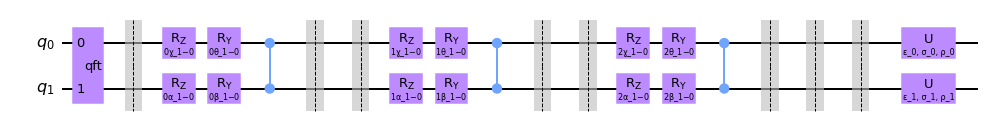

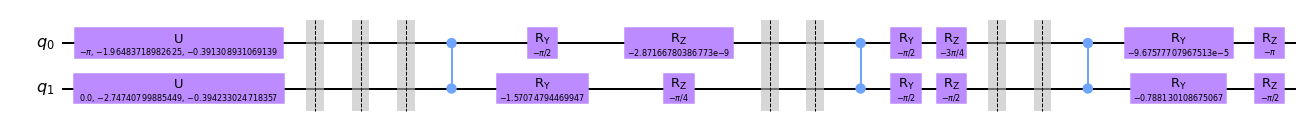

{'00': 0.999999999414944, '01': 2e-15, '10': 5.85055e-10}

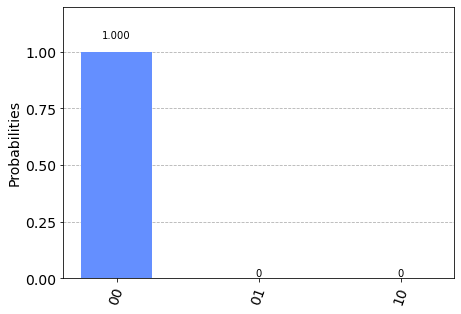

None

{'00': 1024}

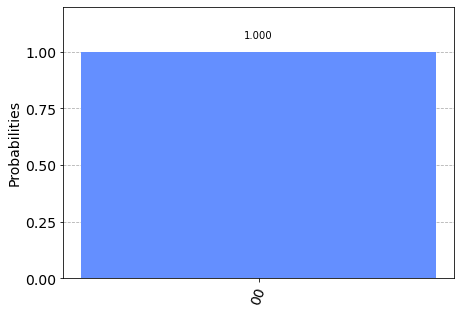

None

Amplitude of 00 = (0.9999999994148625-2.4191301972897872e-05j)
Amplitude of 01 = (3.427738975589623e-08-2.5524584338444212e-08j)
Amplitude of 10 = (2.4187836277483068e-05+5.853807480225769e-08j)
Amplitude of 11 = (-3.2972081833705035e-09+2.0084025746864053e-08j)
Probability of 00 = 0.999999999414944
Probability of 01 = 1.8264438541279713e-15
Probability of 10 = 5.850548504925275e-10
Probability of 11 = 4.1423967200518356e-16


None

In [33]:
Circuito(Param_cz_3,conditions_cz_3,inv=True)

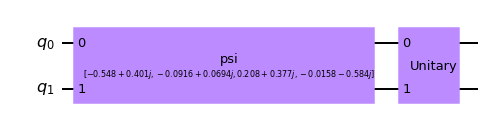

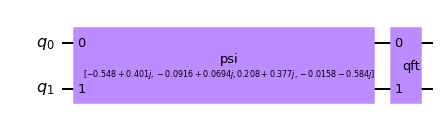

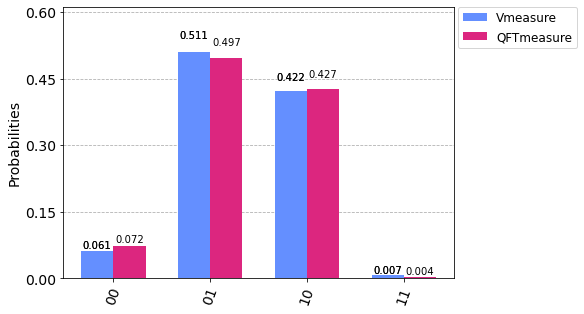

 <Figure size 504x360 with 1 Axes>]

In [34]:
#Ejecutar varias veces la celda para ver como actúa con diferentes vectores aleatorios
TestCircuito(Param_cz_3,conditions_cz_3,inv=True)

In [48]:
# PRINT RESULTS
# Circuito(Param_cz_3,conditions_cz_3,inv=True,display_bool=False,printinfo=[False,"3cz_2qubits.pdf",15,'decomposer'])
# TestCircuito(Param_cz_3,conditions_cz_3,inv=True,display_bool=False,printinfo=[True,"3cz_2qubits_4.pdf",-1,(20,5)])

## 2 qbits: 3CX+14 rotaciones (3 ciclos)

In [49]:
n=2
# limites_puertas=[3,14,63,267]
limites_puertas=[3]
#Nº de ciclos a implementar 
cycles=limites_puertas[0:n-1]
cycles.reverse()
disent_order=list(range(n-1,-1,-1))
dis = disent_dict(disent_order)
mode=['cx','U3']
initial='qft'
conditions_cx_3 = [n,dis,cycles,mode,initial]

# opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# cf_type=['Disentangle','F','merged'/'separated']
opt_type=['Sim',False]
cf_type=['Disentangle','F','merged']

display(conditions_cx_3)

[2, {1: [0], 0: []}, [3], ['cx', 'U3'], 'qft']

In [50]:
Param_cx_3 = retrieve("2qbits_cx_3.txt")

In [58]:
#Valor de la función de coste:
#[FCoste de desentralazamiento, FCoste distancia a la identidad]
MRCF(Param_cx_3,conditions_cx_3,cf_type[0:2],[[True,True,False],[True]*3],False)


Input hasn't changed
Input hasn't changed


[(7.380950336170371e-09+0j), 1.0704421180562917e-06]

In [62]:
MRCF(Param_cx_3,conditions_cx_3,cf_type[0:2],[[True,True,False],[True]*3],True)

Input hasn't changed
Input hasn't changed


(1.077823068392462e-06+0j)

HTest 4.629186479698788e-07
FTest 1.0704421180562917e-06
HTest Fidelity 0.9999996296650816
FTest Fidelity 0.9999995718232101


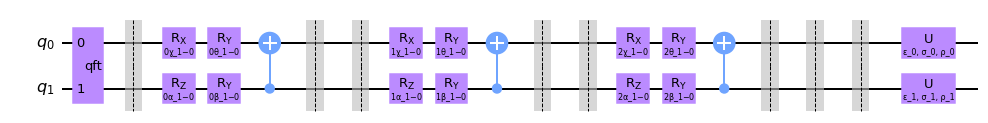

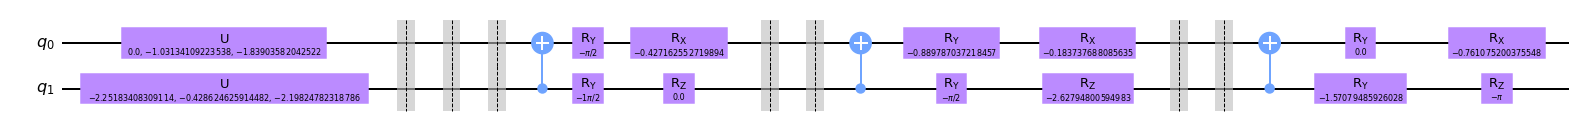

{'00': 0.999999677214826, '01': 1.58e-13, '10': 3.22784879e-07, '11': 1.37e-13}

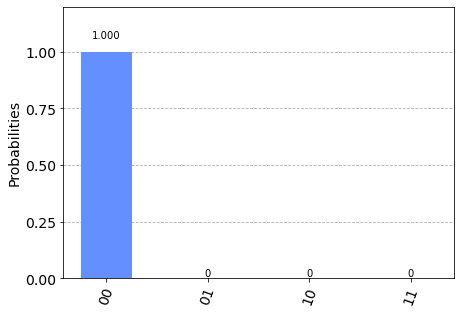

None

{'00': 1024}

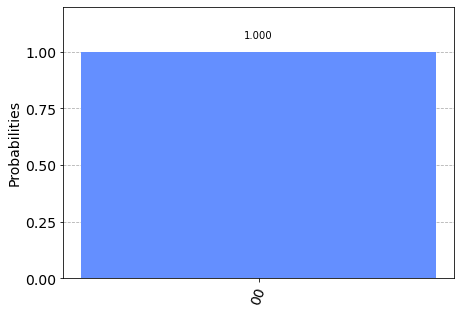

None

Amplitude of 00 = (0.9999995092966092-0.000811554906680223j)
Amplitude of 01 = (-3.2997586986330137e-07+2.2226778850821425e-07j)
Amplitude of 10 = (0.0004518634193606541+0.00034438979221604327j)
Amplitude of 11 = (-3.643534591042387e-07-6.749889539663352e-08j)
Probability of 00 = 0.9999996772148257
Probability of 01 = 1.5828704450037463e-13
Probability of 10 = 3.227848787389119e-07
Probability of 11 = 1.3730954404098985e-13


None

In [52]:
Circuito(Param_cx_3,conditions_cx_3,inv=True)

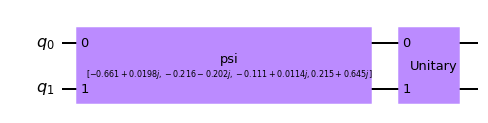

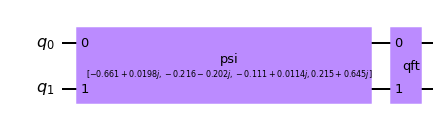

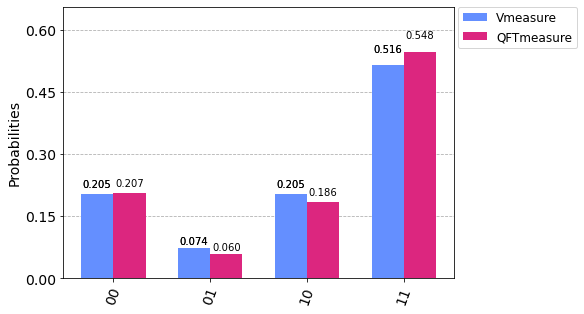

 <Figure size 504x360 with 1 Axes>]

In [53]:
#Ejecutar varias veces la celda para ver como actúa con diferentes vectores aleatorios
TestCircuito(Param_cx_3,conditions_cx_3,inv=True)

In [137]:
# PRINT RESULTS
# Circuito(Param_cx_3,conditions_cx_3,inv=True,display_bool=False,printinfo=[False,"3cx_2qubits.pdf",17,'total'])
# TestCircuito(Param_cx_3,conditions_cx_3,inv=True,display_bool=False,printinfo=[True,"3cx_2qubits_1.pdf",-1,(20,5)])

# A = Circuito(Param_cx_3,conditions_cx_3,inv=True,display_bool=False,printinfo=[False,"3cz_2qubits.pdf",15,'decomposer'])
# RemoveBarriers()(A[1]).draw('mpl',fold=-1).savefig("V_3cx_2qubits.pdf")

## 3qbits: 7CZ + 19 rotaciones  (3ciclos+1ciclo) 

In [63]:
n=3
cycles=[3,1]
disent_order=list(range(n-1,-1,-1))
dis = disent_dict(disent_order)
mode=['cz','U3']
initial='qft'
conditions_cz_3_1 = [n,dis,cycles,mode,initial]
# opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# cf_type=['Disentangle','F','merged'/'separated']
opt_type=['Sim',False]
cf_type=['Disentangle','F','merged']
display(conditions_cz_3_1)

[3, {2: [1, 0], 1: [0], 0: []}, [3, 1], ['cz', 'U3'], 'qft']

### V1

In [64]:
Param_cz_3_1 = retrieve("3qbits_cz_3_1.txt")

In [65]:
Param_cz_3_1

{'Q2': {'C0': {'L1': array([1.22437642, 0.        , 0.78539816, 1.57082904]),
   'L0': array([3.46419914e-01, 1.57076485e+00, 3.13986174e+00, 1.17657878e-06])},
  'C1': {'L1': array([7.37249848e-09, 9.55316615e-01, 0.00000000e+00, 1.04886160e-08]),
   'L0': array([1.57079632, 1.57079632, 1.96522632, 1.57079632])},
  'C2': {'L1': array([2.82322393e-03, 4.61616383e-08, 0.00000000e+00, 2.61799388e+00]),
   'L0': array([1.96067218e+00, 1.57079603e+00, 2.67528321e-10, 1.57079632e+00])}},
 'Q1': {'C0': {'L0': array([1.57078831e+00, 9.55316620e-01, 3.14159265e+00, 4.68465945e-09])}},
 'RF': [array([3.14159264, 0.39270707, 3.14159265]),
  array([1.57079632e+00, 7.85360784e-01, 1.26302031e-05]),
  array([2.64632155e-07, 3.11101887e+00, 3.05825210e-02])]}

In [75]:
#Valor de la función de coste:
#[FCoste de desentralazamiento, FCoste distancia a la identidad]
MRCF(Param_cz_3_1,conditions_cz_3_1,cf_type[0:2],[[True,True,False],[True]*3],False)

Input hasn't changed
Input hasn't changed


[(8.812086457119158e-12+0j), 3.653157776284388e-10]

HTest 7.522094058742823e-11
FTest 3.653175539852782e-10
HTest Fidelity 0.9999999999331369
FTest Fidelity 0.9999999999188183


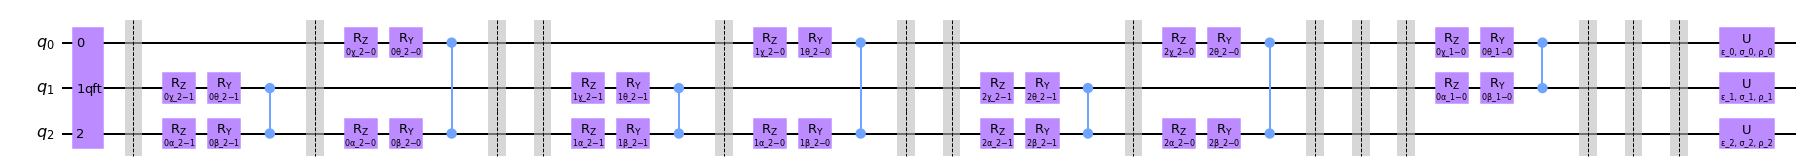

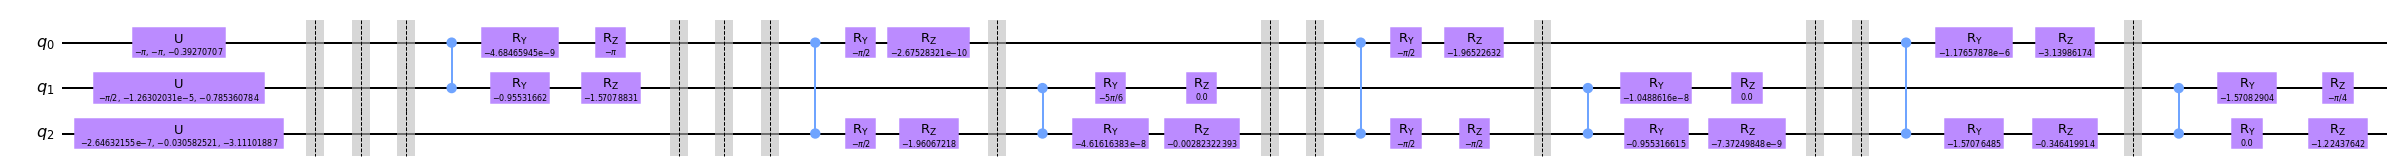

{'000': 0.99999999998609, '010': 1.372e-11, '100': 9e-14, '110': 9.9e-14}

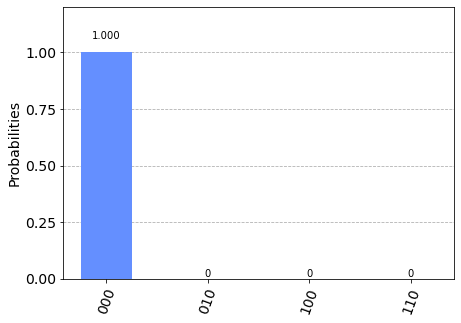

None

{'000': 1024}

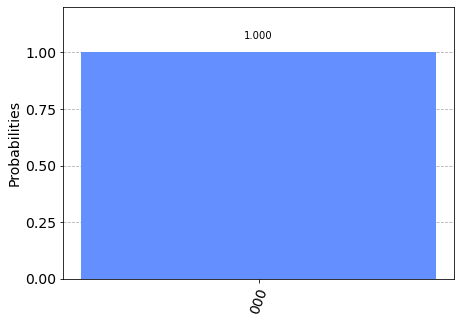

None

Amplitude of 000 = (0.9999999999068405-1.3130481932126796e-05j)
Amplitude of 001 = (-1.1947636860238085e-08-7.722723217783637e-09j)
Amplitude of 010 = (2.61725350902709e-06-2.6210998604691856e-06j)
Amplitude of 011 = (1.9582933732039474e-09-8.079242205422617e-09j)
Amplitude of 100 = (3.004742394232113e-07+6.84452342522123e-09j)
Amplitude of 101 = (1.6029245713595862e-10-3.161051392060857e-09j)
Amplitude of 110 = (-2.217433722611701e-07-2.2255636762781103e-07j)
Amplitude of 111 = (4.203419972880468e-09+3.997548958747444e-09j)
Probability of 000 = 0.9999999999860905
Probability of 001 = 2.0238648044261424e-16
Probability of 010 = 1.3720180409066201e-11
Probability of 011 = 6.91090675494166e-17
Probability of 100 = 9.033161605787571e-14
Probability of 101 = 1.0017939575064566e-17
Probability of 110 = 9.870145991344123e-14
Probability of 111 = 3.364913714599321e-17


None

In [67]:
Circuito(Param_cz_3_1,conditions_cz_3_1,inv=True)

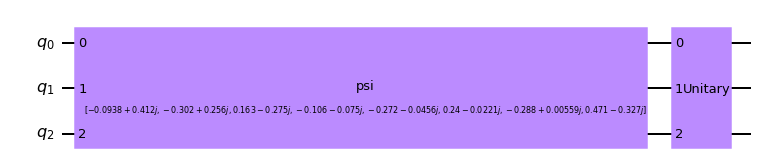

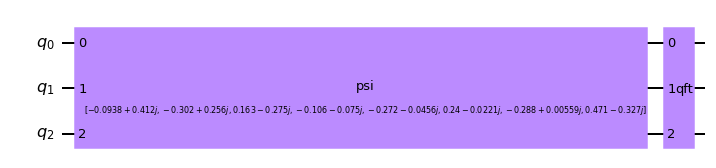

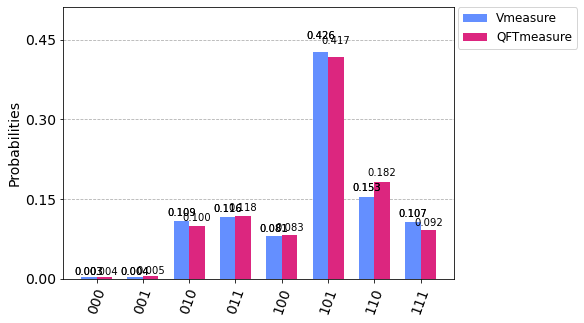

 <Figure size 504x360 with 1 Axes>]

In [68]:
#Ejecutar varias veces la celda para ver como actúa con diferentes vectores aleatorios
TestCircuito(Param_cz_3_1,conditions_cz_3_1,inv=True)

In [138]:
# PRINT RESULTS
# Circuito(Param_cz_3_1,conditions_cz_3_1,inv=True,display_bool=False,printinfo=[True,"3_1_cz_3qubits.pdf",28,'total'])
# TestCircuito(Param_cz_3_1,conditions_cz_3_1,inv=True,display_bool=False,printinfo=[True,"3_1_cz_3qubits_4.pdf",-1,(28,5)])
# from qiskit.transpiler.passes import RemoveBarriers
# A = Circuito(Param_cz_3_1,conditions_cz_3_1,inv=True,display_bool=False,printinfo=[False,"3_1_cz_3qubits.pdf",28,'decomposer'])
# RemoveBarriers()(A[1]).draw('mpl',fold=20).savefig("V_3_1_cz_3qubits.pdf")

### V2

In [76]:
conditions_cz_3_1_V2=copy.deepcopy(conditions_cz_3_1)

In [77]:
conditions_cz_3_1_V2

[3, {2: [1, 0], 1: [0], 0: []}, [3, 1], ['cz', 'U3'], 'qft']

In [78]:
Param_cz_3_1_V2 = retrieve("3qbits_cz_3_1_V2.txt")

In [79]:
Param_cz_3_1_V2

{'Q2': {'C0': {'L1': array([1.40115353e+00, 1.78467138e-17, 6.17093684e-01, 0.00000000e+00]),
   'L0': array([0.16964277, 2.35619449, 1.77782847, 0.        ])},
  'C1': {'L1': array([3.14159263, 1.57079631, 0.57977221, 3.14159264]),
   'L0': array([1.97679959e-09, 3.92699082e-01, 1.85663900e-01, 1.57079632e+00])},
  'C2': {'L1': array([0.        , 0.        , 0.41146774, 0.78539816]),
   'L0': array([0.00000000e+00, 1.57079633e+00, 1.41686528e-08, 1.57079632e+00])}},
 'Q1': {'C0': {'L0': array([1.57079631e+00, 5.95144663e-10, 3.85391810e-19, 1.35644227e-08])}},
 'RF': [array([1.57079632, 1.96349542, 1.57079631]),
  array([1.57079633, 2.35619451, 3.14159264]),
  array([3.14159046, 2.35619452, 2.35619451])]}

In [87]:
#Valor de la función de coste:
#[FCoste de desentralazamiento, FCoste distancia a la identidad]
MRCF(Param_cz_3_1_V2,conditions_cz_3_1_V2,cf_type[0:2],[[True,True,False],[True]*3],True)

Input hasn't changed
Input hasn't changed


(4.6321858149085325e-12+0j)

HTest 1.156408302449563e-12
FTest 4.6282977450573526e-12
HTest Fidelity 0.999999999998972
FTest Fidelity 0.9999999999989715


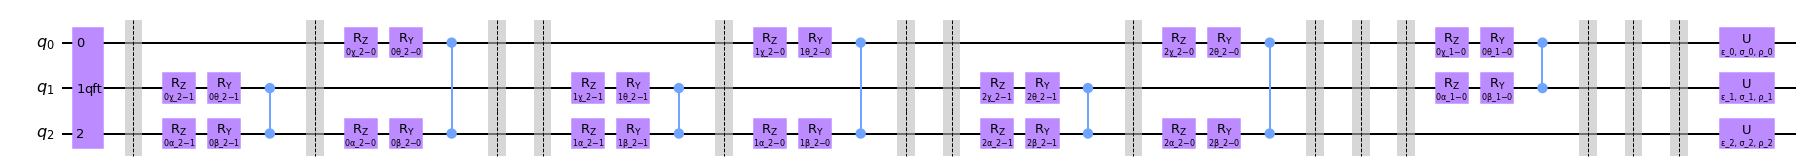

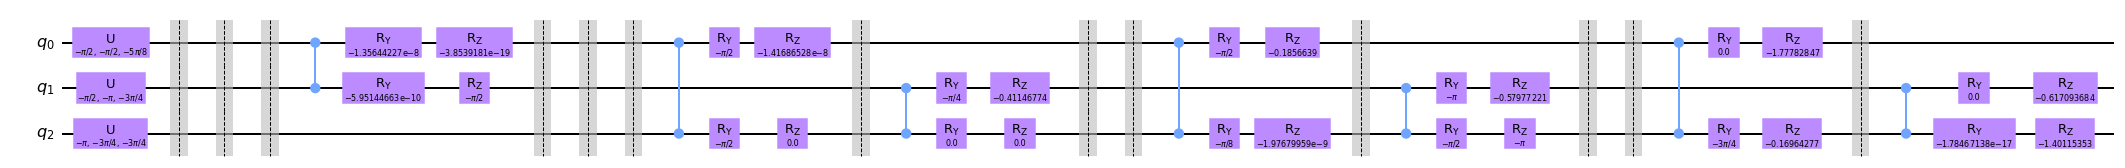

{'000': 0.999999999998843, '100': 1.157e-12}

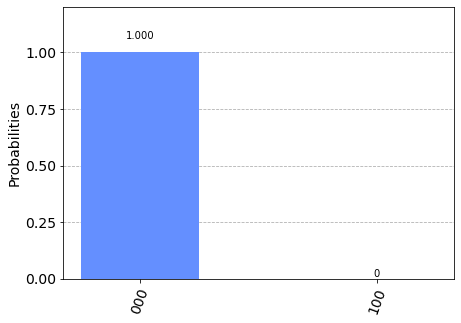

None

{'000': 1024}

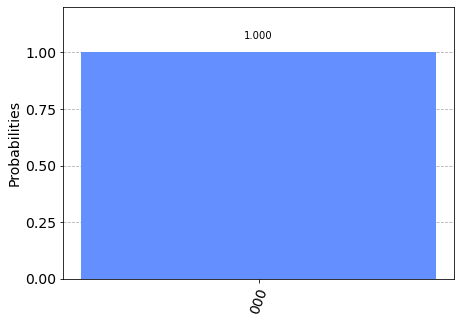

None

Amplitude of 000 = (0.9999999999994215+4.614130617180753e-09j)
Amplitude of 001 = (7.088467200371082e-09-1.15064798524098e-09j)
Amplitude of 010 = (1.9185003646277818e-09-4.2126076800977814e-09j)
Amplitude of 011 = (2.882944028584072e-09+6.960050332843386e-09j)
Amplitude of 100 = (7.75551113531628e-07+7.452438149913292e-07j)
Amplitude of 101 = (-3.756301261889088e-09+6.682324361790965e-09j)
Amplitude of 110 = (-6.5961603379101075e-09-1.8012853193372417e-09j)
Amplitude of 111 = (2.800686781037138e-09-1.1600758047383797e-09j)
Probability of 000 = 0.9999999999988429
Probability of 001 = 5.157035803667577e-17
Probability of 010 = 2.142670711549574e-17
Probability of 011 = 5.67536669076619e-17
Probability of 100 = 1.156867873482979e-12
Probability of 101 = 5.876325804625458e-17
Probability of 110 = 4.6753960005078246e-17
Probability of 111 = 9.189622318215565e-18


None

In [81]:
Circuito(Param_cz_3_1_V2,conditions_cz_3_1_V2,inv=True)

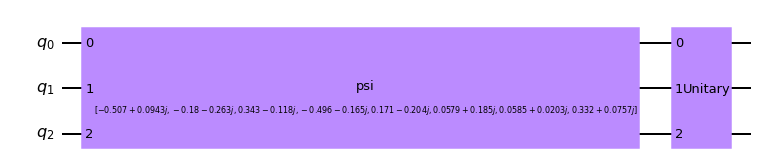

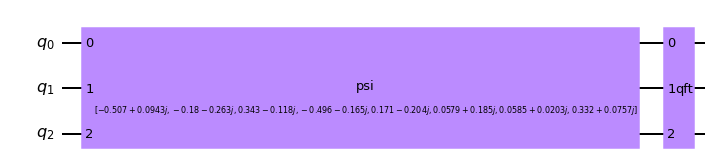

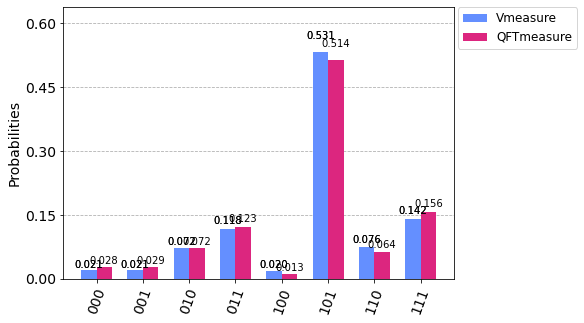

 <Figure size 504x360 with 1 Axes>]

In [82]:
#Ejecutar varias veces la celda para ver como actúa con diferentes vectores aleatorios
TestCircuito(Param_cz_3_1_V2,conditions_cz_3_1_V2,inv=True)

In [139]:
# PRINT RESULTS
# Circuito(Param_cz_3_1_V2,conditions_cz_3_1_V2,inv=True,display_bool=False,printinfo=[True,"3_1_cz_3qubits_V2.pdf",25,'total'])
# TestCircuito(Param_cz_3_1_V2,conditions_cz_3_1_V2,inv=True,display_bool=False,printinfo=[True,"3_1_cz_3qubits_V2_1.pdf",20,(30,5)])
# from qiskit.transpiler.passes import RemoveBarriers
# A = Circuito(Param_cz_3_1_V2,conditions_cz_3_1_V2,inv=True,display_bool=False,printinfo=[False,"3_1_cz_3qubits.pdf",28,'decomposer'])
# RemoveBarriers()(A[1]).draw('mpl',fold=16).savefig("V_3_1_cz_3qubits_V2.pdf")

## 3qbits: 7CX + 19 rotaciones  (3ciclos+1ciclo) 

In [88]:
n=3
cycles=[3,1]
disent_order=list(range(n-1,-1,-1))
dis = disent_dict(disent_order)
mode=['cx','U3']
initial='qft'
conditions_cx_3_1 = [n,dis,cycles,mode,initial]
# opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# cf_type=['Disentangle','F','merged'/'separated']
opt_type=['Sim',False]
cf_type=['Disentangle','F','merged']
display(conditions_cx_3_1)

[3, {2: [1, 0], 1: [0], 0: []}, [3, 1], ['cx', 'U3'], 'qft']

In [89]:
Param_cx_3_1 = retrieve("3qbits_cx_3_1.txt")

In [90]:
Param_cx_3_1

{'Q2': {'C0': {'L1': array([6.34998197e-09, 1.57079629e+00, 1.57079347e+00, 2.35619451e+00]),
   'L0': array([1.18535740e+00, 1.57079631e+00, 1.16520938e-08, 1.57079634e+00])},
  'C1': {'L1': array([1.5707963 , 1.17809724, 3.14159062, 0.78539817]),
   'L0': array([0.        , 0.78539816, 1.96349539, 1.57079632])},
  'C2': {'L1': array([0.00000000e+00, 0.00000000e+00, 8.27694773e-09, 1.69773143e-11]),
   'L0': array([0.00000000e+00, 1.57079632e+00, 1.42017986e-10, 1.57079632e+00])}},
 'Q1': {'C0': {'L0': array([1.52774701e+00, 1.24288186e-08, 1.57079631e+00, 1.57079627e+00])}},
 'RF': [array([1.57079628e+00, 1.57805650e+00, 3.44788116e-08]),
  array([1.57079625, 0.78539956, 1.61384564]),
  array([3.14159265, 0.171194  , 0.17119406])]}

In [97]:
#Valor de la función de coste:
#[FCoste de desentralazamiento, FCoste distancia a la identidad]
MRCF(Param_cx_3_1,conditions_cx_3_1,cf_type[0:2],[[True,True,False],[True]*3],True)

Input hasn't changed
Input hasn't changed


(1.0243715526392005e-11+0j)

HTest 5.155875726359227e-13
FTest 2.0730084315800923e-12
HTest Fidelity 0.9999999999995417
FTest Fidelity 0.9999999999995394


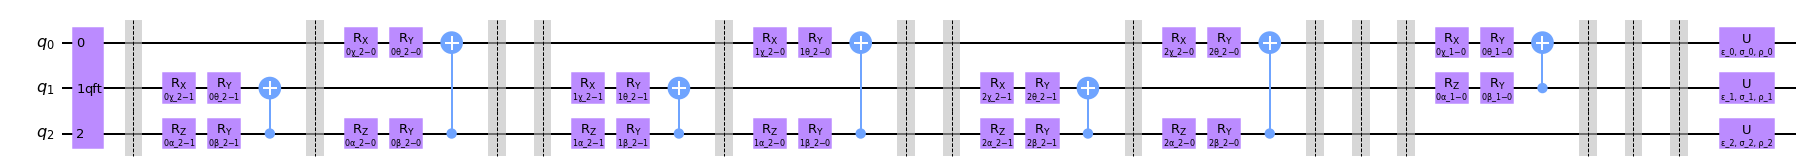

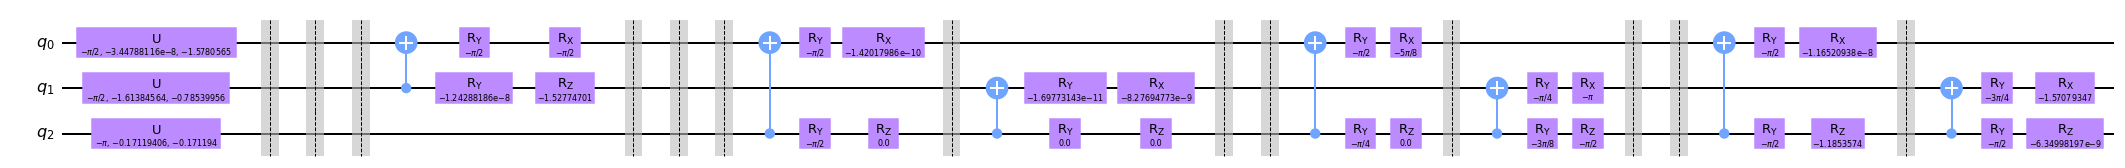

{'000': 0.999999999999481,
 '001': 2e-15,
 '010': 2.57e-13,
 '011': 1e-15,
 '110': 2.59e-13}

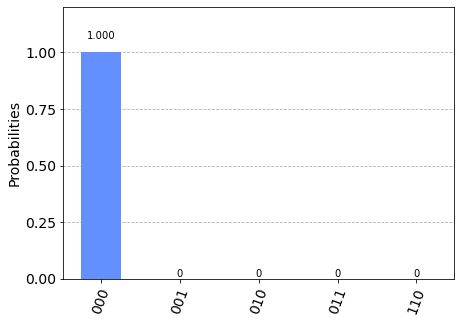

None

{'000': 1024}

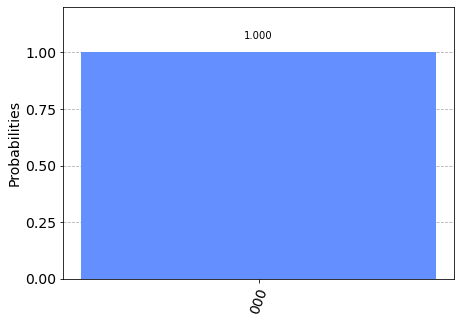

None

Amplitude of 000 = (0.9999999999997403-1.2222107011360136e-08j)
Amplitude of 001 = (2.0091909392701223e-08-3.5169261668455045e-08j)
Amplitude of 010 = (3.378634301689312e-07-3.7858080802383944e-07j)
Amplitude of 011 = (2.4533755858875147e-08-1.5391426983841598e-08j)
Amplitude of 100 = (-8.37119009044607e-09+8.091672955446996e-09j)
Amplitude of 101 = (4.928084954349272e-09+1.1198535219646296e-09j)
Amplitude of 110 = (3.5288799035465327e-07+3.6609454885735844e-07j)
Amplitude of 111 = (-1.4518757293262791e-09-3.986338028075804e-09j)
Probability of 000 = 0.9999999999994806
Probability of 001 = 1.6405617893487768e-15
Probability of 010 = 2.5747512564949934e-13
Probability of 011 = 8.388012011418179e-16
Probability of 100 = 1.355519947482948e-16
Probability of 101 = 2.554009322794025e-17
Probability of 110 = 2.585551524396186e-13
Probability of 111 = 1.7998834007490002e-17


None

In [92]:
Circuito(Param_cx_3_1,conditions_cx_3_1,inv=True)

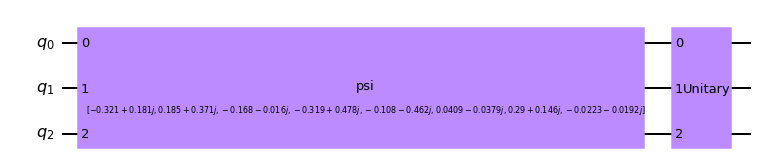

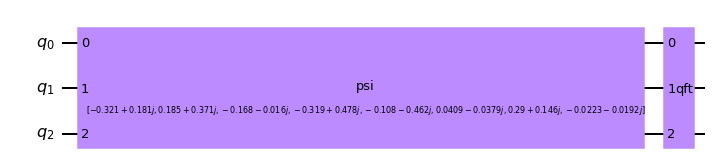

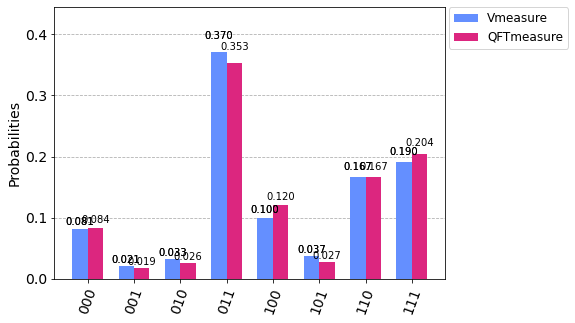

 <Figure size 504x360 with 1 Axes>]

In [93]:
#Ejecutar varias veces la celda para ver como actúa con diferentes vectores aleatorios
TestCircuito(Param_cx_3_1,conditions_cx_3_1,inv=True)

In [140]:
# PRINT RESULTS
# Circuito(Param_cx_3_1,conditions_cx_3_1,inv=True,display_bool=False,printinfo=[True,"3_1_cx_3qubits.pdf",28,'total'])
# TestCircuito(Param_cx_3_1,conditions_cx_3_1,inv=True,display_bool=False,printinfo=[True,"3_1_cx_3qubits_4.pdf",20,(30,5)])
# A = Circuito(Param_cx_3_1,conditions_cx_3_1,inv=True,display_bool=False,printinfo=[False,"3_1_cz_3qubits.pdf",28,'decomposer'])
# RemoveBarriers()(A[1]).draw('mpl',fold=16).savefig("V_3_1_cx_3qubits.pdf")

## 3 qbits: 8CZ+35 rotaciones (3ciclos+2ciclos)

In [311]:
n=3
# limites_puertas=[3,14,63,267]
# limites_puertas=[2,3]
# #Nº de ciclos a implementar 
# cycles=limites_puertas[0:n-1]
# cycles.reverse()
cycles=[3,2]
disent_order=list(range(n-1,-1,-1))
dis = disent_dict(disent_order)
mode=['cz','U3']
initial='qft'
conditions_cz_3_2 = [n,dis,cycles,mode,initial]

# opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# cf_type=['Disentangle','F','merged'/'separated']
opt_type=['Sim',False]
cf_type=['Disentangle','F','merged']

display(conditions_cz_3_2)

[3, {2: [1, 0], 1: [0], 0: []}, [3, 2], ['cz', 'U3'], 'qft']

In [312]:
Param_cz_3_2 = retrieve("3qbits_cz_3_2.txt")

In [313]:
#Valor de la función de coste:
#[FCoste de desentralazamiento, FCoste distancia a la identidad]
MRCF(Param_cz_3_2,conditions_cz_3_2,cf_type[0:2],[[True,True,False],[True]*3],False)

Input hasn't changed
Input hasn't changed


[(3.1852302481173275e-08+0j), 3.2522263104795e-07]

HTest 7.998652451490784e-08
FTest 3.2522263282430686e-07
HTest Fidelity 0.9999999289008671
FTest Fidelity 0.9999999277283053


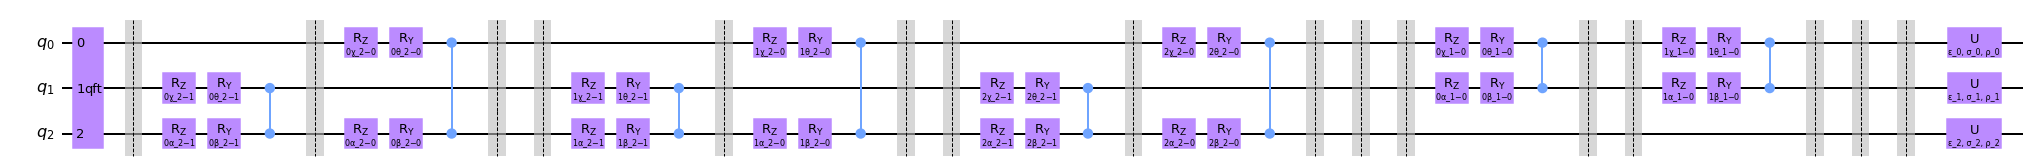

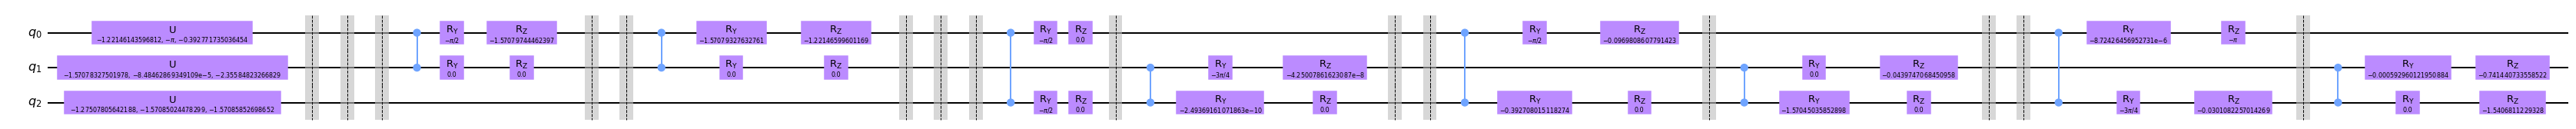

{'000': 0.999999923548936,
 '010': 7.4433866e-08,
 '011': 4.89e-13,
 '100': 9.29229e-10,
 '101': 8.9e-13,
 '110': 1.08137e-09,
 '111': 5.222e-12}

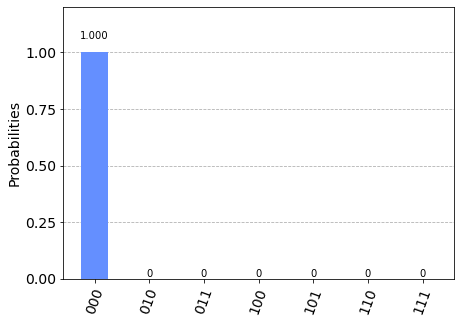

None

{'000': 1024}

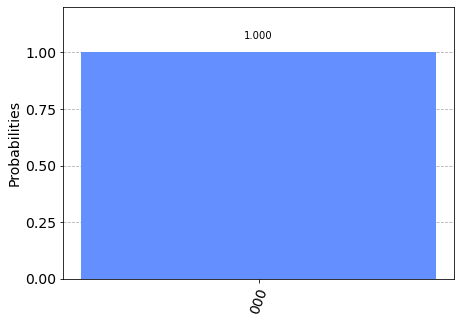

None

Amplitude of 000 = (0.9999999521538766-0.00013871258313655557j)
Amplitude of 001 = (1.954456414983578e-09+9.227706701431885e-10j)
Amplitude of 010 = (-0.00016545000036973683+0.00021693354658923705j)
Amplitude of 011 = (-2.532912102411635e-07-6.517545379912301e-07j)
Amplitude of 100 = (3.015344398964011e-05-4.471955967013257e-06j)
Amplitude of 101 = (-3.604375425030146e-07+8.716217648177933e-07j)
Amplitude of 110 = (-1.8445033324662217e-05-2.7224086667075693e-05j)
Amplitude of 111 = (-2.1111286977824545e-06+8.745936860847548e-07j)
Probability of 000 = 0.9999999235489362
Probability of 001 = 4.671405587746969e-18
Probability of 010 = 7.443386625813061e-08
Probability of 011 = 4.889404149775951e-13
Probability of 100 = 9.292285746072688e-10
Probability of 101 = 8.89639722949697e-13
Probability of 110 = 1.0813701492043484e-09
Probability of 111 = 5.221778494339961e-12


None

In [314]:
Circuito(Param_cz_3_2,conditions_cz_3_2,inv=True)

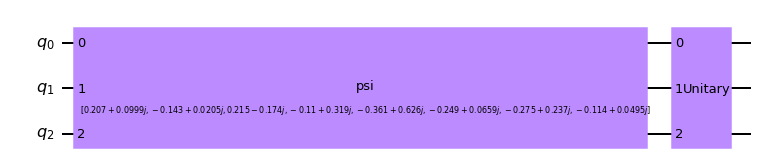

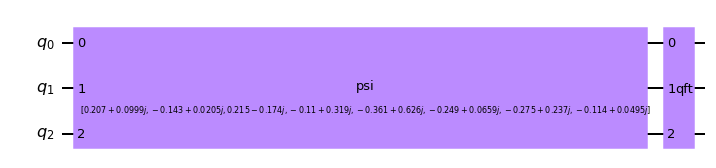

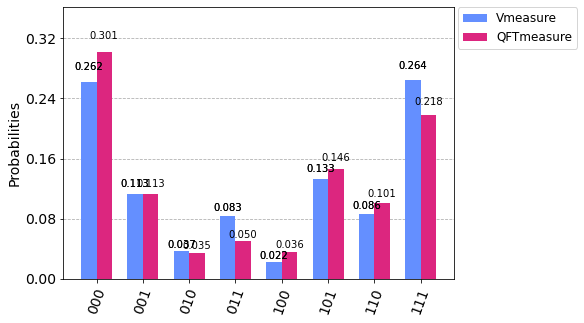

 <Figure size 504x360 with 1 Axes>]

In [315]:
#Ejecutar varias veces la celda para ver como actúa con diferentes vectores aleatorios
TestCircuito(Param_cz_3_2,conditions_cz_3_2,inv=True)

In [316]:
# PRINT RESULTS
# Circuito(Param_cz_3_2,Param_cz_3_2,inv=True,display_bool=False,printinfo=[False,"3_1_cx_3qubits.pdf",28,'total'])
# TestCircuito(Param_cx_3_1,Param_cz_3_2,inv=True,display_bool=False,printinfo=[True,"3_1_cx_3qubits_4.pdf",20,(30,5)])

# 3 qbits: 8CX+35 rotaciones (3ciclos+2ciclos)

In [113]:
# n=3
# # limites_puertas=[3,14,63,267]
# limites_puertas=[2,3]
# #Nº de ciclos a implementar 
# cycles=limites_puertas[0:n-1]
# cycles.reverse()
# disent_order=list(range(n-1,-1,-1))
# dis = disent_dict(disent_order)
# mode=['cx','U3']
# initial='qft'
# conditions_cx_2_3 = [n,dis,cycles,mode,initial]

# # opt_type=['It'/'Sim',minimize_Iterations=True/False,]
# # cf_type=['Disentangle','F','merged'/'separated']
# opt_type=['Sim',False]
# cf_type=['Disentangle','F','merged']

# display(conditions_cx_2_3)

In [114]:
# Param_cx_2_3 = retrieve("3qbits_cx_2_3.txt")

In [68]:
# Circuito(Param_cx_2_3,conditions_cx_2_3,inv=True)

-------------------------------------------------------------------------------------